# Comparing with other methods for copula estimation and with different DRE methods

In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1 - Using F-DRE

In [13]:
data_p.shape

torch.Size([1000, 2])

In [14]:
def get_q(data_p):
    ''' 
    Shuffle data_p dimension-zise to break dependence
    '''
    data_q = np.copy(data_p)
    n_dim = data_p.shape[1]
    for dim in range(n_dim):
        np.random.shuffle(data_q[:, dim])
    return torch.tensor(data_q)

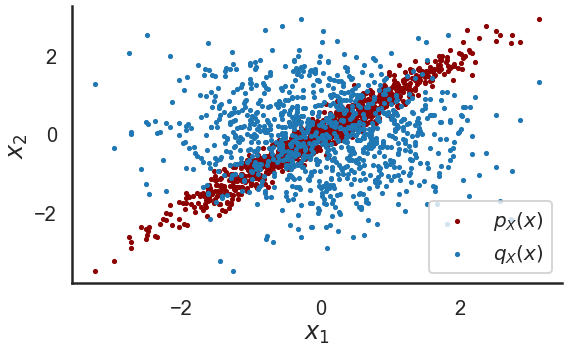

In [20]:
N = 1000
p = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0.97], [0.97, 1.0]]))
data_p = p.sample((N,))
data_q = get_q(data_p)
true_xs = torch.cat([data_p, data_q])
true_xs.shape

plt.figure(figsize=(8,5))
plt.scatter(data_p[:,0], data_p[:,1], label=r'$p_X(x)$', s=10, color='darkred')
plt.scatter(data_q[:,0], data_q[:,1], label=r'$q_X(x)$', s=10, color='tab:blue')

plt.legend(loc='lower right', fontsize=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
sns.despine()

### Train z-map

In [33]:
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            3, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)

class MLPClassifierv2(nn.Module):
  """
  simple MLP classifier (e.g. for classifying in z-space)
  slightly deeper than MLPClassifier
  """
  def __init__(self, h_dim=100, in_dim=2):
      super(MLPClassifierv2, self).__init__()
      self.h_dim = h_dim
      self.in_dim = in_dim

      self.fc1 = nn.Linear(self.in_dim, self.h_dim)
      self.fc2 = nn.Linear(self.h_dim, self.h_dim)
      self.fc3 = nn.Linear(self.h_dim, self.h_dim)
      self.fc4 = nn.Linear(self.h_dim, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    r = self.fc4(x)

    return r

mlp = MLPClassifierv2()

def Logistic_loss(r_p,r_q):
    '''
    Vectorised version of the logistic loss function from TRE eq(1)
    '''
    return -(r_p /(1+r_p)).log() - (1/(1+r_q)).log() 

In [34]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

optimizer = torch.optim.Adam(model.parameters())
epochs = 100
loss_history = []
param_history = []

for epoch in range(epochs):  # number of epochs
    perm = torch.randperm(true_xs.size(0))
    idx = perm[:500]
    sub_samples = true_xs[idx]
    optimizer.zero_grad()
    log_prob = model.log_prob(sub_samples)
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()
    #data_q = get_q(data_p)
    #true_xs = torch.cat([data_p, data_q])
    with torch.no_grad():
        loss_history.append(loss.item())
        param_history.append(model._parameters)
        if epoch % round(epochs/20) == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))
            
            


Epoch: 0, Loss: 2.7585
Epoch: 5, Loss: 2.7262
Epoch: 10, Loss: 2.5470
Epoch: 15, Loss: 2.6243
Epoch: 20, Loss: 2.7001
Epoch: 25, Loss: 2.5804
Epoch: 30, Loss: 2.5631
Epoch: 35, Loss: 2.6853
Epoch: 40, Loss: 2.6126
Epoch: 45, Loss: 2.5536
Epoch: 50, Loss: 2.5933
Epoch: 55, Loss: 2.5605
Epoch: 60, Loss: 2.4841
Epoch: 65, Loss: 2.4148
Epoch: 70, Loss: 2.4704
Epoch: 75, Loss: 2.6002
Epoch: 80, Loss: 2.4390
Epoch: 85, Loss: 2.4819
Epoch: 90, Loss: 2.5216
Epoch: 95, Loss: 2.4615


Text(0.5, 1.0, 'Training loss')

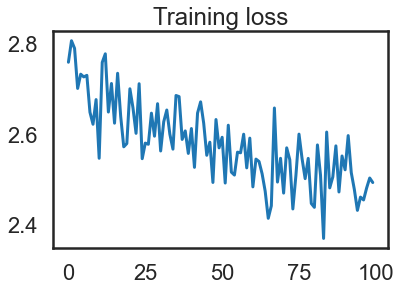

In [35]:
plt.plot(loss_history)
plt.title('Training loss')


In [48]:
model.forward(torch.tensor([[0.0, 0.0],[1.2,1.3]]))

(tensor([[ 0.7078, -0.7078],
         [-0.7078,  0.7078]], grad_fn=<AddBackward0>),
 tensor([[1.5791, 1.3160],
         [1.5626, 1.1978]], grad_fn=<AddBackward0>))

In [52]:
model.forward(torch.tensor([[4.0, 0.3],[10.1,1.3]]))

(tensor([[-0.7078,  0.7078],
         [ 0.7078, -0.7078]], grad_fn=<AddBackward0>),
 tensor([[-2.3761,  1.9726],
         [-2.3597,  1.7012]], grad_fn=<AddBackward0>))

In [56]:
z_pq = model.forward(true_xs)[0]
z_p = model.forward(data_p)[0]
z_q = model.forward(data_q)[0]

(-5.0, 5.0)

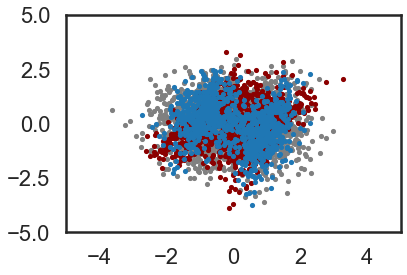

In [57]:
plt.scatter(z_pq[:,0].data.cpu().numpy(), z_pq[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='Grey')
plt.scatter(z_p[:,0].data.cpu().numpy(), z_p[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='darkred')
plt.scatter(z_q[:,0].data.cpu().numpy(), z_q[:,1].data.cpu().numpy(), label=r'$q_Z(z)$', s=10, color='tab:blue')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

### Train ratio function

In [71]:
optimizer = torch.optim.Adam(mlp.parameters())
epochs = 100
loss_history = []

for epoch in range(epochs):  
    optimizer.zero_grad()
    r_p = mlp(z_p)
    r_q = mlp(z_q)
    loss = torch.mean(Logistic_loss(r_p,r_q))
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        loss_history.append(loss.item())
        if epoch % round(epochs/20) == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))

AttributeError: 'TensorDataset' object has no attribute 'shape'